## Anomaly Detection for Fundão dam in Mariana-MG
#### Period: 2013 to 2020;
#### Tools: Google Earth Engine Python API, Sentinel Images, Pandas, Numpy, Scikit-Learn.

In [1]:
import ee
from osgeo import gdal
from osgeo import osr
import pandas as pd
import numpy as np
import time
import logging
import requests
import zipfile
import os

#from save_gee_image_tiff import save_gee_tiff
ee.Initialize()

In [2]:
coordenadas = "-43.49513553785783,-20.24537533206166,-43.42406772779923,-20.191089981448055"
x1,y1,x2,y2 = coordenadas.split(",")
geometria = geometry = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])
datas = "2013-01-01,2021-12-31"
inicio,fim = datas.split(",")
colecao = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filterBounds(geometria).filterDate(inicio,fim).filterMetadata('CLOUD_COVER','less_than', 10).sort('system:time_start')
print("Total de imagens encontradas: "+str(colecao.size().getInfo()))

Total de imagens encontradas: 79


In [3]:
blue = 'B2'; green = 'B3'; red = 'B4'; nir = 'B5'; swir2 = 'B7' ; pan = 'B8'

def ndvi(imagem):
    ndvi = imagem.expression('(nir - red) / (nir + red)',{'nir':imagem.select(nir),'red':imagem.select(red)}).rename('ndvi')
    return imagem.addBands(ndvi)

def ndwi(imagem):
    ndwi = imagem.expression('(nir - green) / (nir + green)',{'nir':imagem.select(nir),'green':imagem.select(green)}).rename('ndwi')
    return imagem.addBands(ndwi)

#gvmi = (nir + )
def gvmi(imagem):
    gvmi = imagem.expression('(nir - swir2 + 0.12) / (nir + swir2 + 0.12)',{'nir':imagem.select(nir),'swir2':imagem.select(swir2)}).rename('gvmi')
    return imagem.addBands(gvmi)

#colecao = colecao.map(ndvi)
#colecao = colecao.map(ndwi)
colecao = colecao.map(gvmi)
imagem = colecao.median()
print(imagem.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA', 'gvmi']


In [4]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=30,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [5]:
reduce_ndvi = create_reduce_region_function(
    geometry=geometria, reducer=ee.Reducer.mean(), scale=30)

ndvi_stat_fc = ee.FeatureCollection(colecao.map(reduce_ndvi)).filter(
    ee.Filter.notNull(colecao.first().bandNames()))

ndvi_dict = fc_to_dict(ndvi_stat_fc).getInfo()
ndvi_df = pd.DataFrame(ndvi_dict)
display(ndvi_df)
print(ndvi_df.dtypes)

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,B9,BQA,gvmi,millis,system:index
0,0.107838,297.129439,295.867752,0.085986,0.070131,0.060592,0.200036,0.137215,0.078895,0.065425,0.001149,2720.000603,0.613549,1367758751640,LC08_218074_20130505
1,0.158616,292.074782,289.912765,0.136212,0.114299,0.104132,0.226920,0.158861,0.096200,0.110770,0.000865,2764.276696,0.618194,1369141164700,LC08_218074_20130521
2,0.128951,292.691723,291.200848,0.106096,0.086842,0.078109,0.199738,0.148214,0.090763,0.082738,0.001062,2752.990192,0.597145,1373288362150,LC08_218074_20130708
3,0.111479,294.288711,293.538826,0.089184,0.072319,0.064473,0.185809,0.141579,0.086095,0.068271,0.001118,2720.003615,0.575589,1375447992400,LC08_217074_20130802
4,0.118936,292.994597,291.023212,0.096371,0.078933,0.071942,0.185433,0.141744,0.086775,0.075537,0.004094,2721.170736,0.573434,1376053163530,LC08_218074_20130809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.110220,293.666934,292.898599,0.088419,0.073360,0.063935,0.202544,0.137427,0.080195,0.068725,0.000971,2720.008865,0.612611,1620737815410,LC08_218074_20210511
75,0.110111,292.298412,291.920026,0.087956,0.071181,0.063459,0.181010,0.134615,0.082042,0.067004,0.001031,2720.001808,0.590056,1624885036169,LC08_218074_20210628
76,0.126517,292.610991,291.662829,0.103742,0.084858,0.077669,0.187365,0.145011,0.091104,0.080918,0.001241,2745.322219,0.592174,1626267437384,LC08_218074_20210714
77,0.123432,288.989994,288.403817,0.100432,0.081852,0.075970,0.175376,0.142267,0.091709,0.078887,0.001210,2720.443508,0.546937,1627649845535,LC08_218074_20210730


B1              float64
B10             float64
B11             float64
B2              float64
B3              float64
B4              float64
B5              float64
B6              float64
B7              float64
B8              float64
B9              float64
BQA             float64
gvmi            float64
millis            int64
system:index     object
dtype: object


In [6]:
ndvi_df = add_date_info(ndvi_df)
ndvi_df.tail(5)

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,B9,BQA,gvmi,millis,system:index,Timestamp,Year,Month,Day,DOY
74,0.110220,293.666934,292.898599,0.088419,0.073360,0.063935,0.202544,0.137427,0.080195,0.068725,0.000971,2720.008865,0.612611,1620737815410,LC08_218074_20210511,2021-05-11 12:56:55.410,2021,5,11,131
75,0.110111,292.298412,291.920026,0.087956,0.071181,0.063459,0.181010,0.134615,0.082042,0.067004,0.001031,2720.001808,0.590056,1624885036169,LC08_218074_20210628,2021-06-28 12:57:16.169,2021,6,28,179
76,0.126517,292.610991,291.662829,0.103742,0.084858,0.077669,0.187365,0.145011,0.091104,0.080918,0.001241,2745.322219,0.592174,1626267437384,LC08_218074_20210714,2021-07-14 12:57:17.384,2021,7,14,195
77,0.123432,288.989994,288.403817,0.100432,0.081852,0.075970,0.175376,0.142267,0.091709,0.078887,0.001210,2720.443508,0.546937,1627649845535,LC08_218074_20210730,2021-07-30 12:57:25.535,2021,7,30,211
78,0.169991,292.522456,290.970724,0.150344,0.131563,0.128595,0.221127,0.191233,0.133775,0.130349,0.001243,2802.247181,0.497823,1629032251716,LC08_218074_20210815,2021-08-15 12:57:31.716,2021,8,15,227


In [7]:
import altair as alt
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

base = alt.Chart(ndvi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y('gvmi:Q', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('gvmi:Q', title='GVMI')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

(points + lines).properties(width=600, height=350).interactive()

alt.LayerChart(...)

In [8]:
base = alt.Chart(ndvi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(0, 360))))

line = base.mark_line().encode(
    y=alt.Y('median(gvmi):Q', scale=alt.Scale(domain=(0, 1))))

band = base.mark_errorband(extent='iqr').encode(
    y='gvmi:Q')

(line + band).properties(width=600, height=300).interactive()

alt.LayerChart(...)

In [9]:
def ext_lat_lon_pixel30(image, geometria, bandas):
    image = image.addBands(ee.Image.pixelLonLat())
    coordenadas = image.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=30,bestEffort=True)
    bandas_valores = []
    for banda in bandas:
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))

    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

In [10]:
listaColecao = colecao.toList(colecao.size())
lista_sm = ee.List([])
for im in range(colecao.size().getInfo()):
    sub_med = ee.Image(listaColecao.get(im)).subtract(imagem)
    lista_sm = lista_sm.add(sub_med)
    
col_ajust = ee.ImageCollection(lista_sm)

In [11]:
listaCN = col_ajust.toList(col_ajust.size())
defaultDummy = -99999
df_r30 = pd.DataFrame()
dias = ndvi_df['Timestamp'].values
di = {}
for j in range(col_ajust.size().getInfo()):
    tempndvi = dias[j]
    img = ee.Image(defaultDummy).blend(ee.Image(listaCN.get(j)))
    lat30, lon30, ind30 = ext_lat_lon_pixel30(img,geometria,['gvmi'])
    di[tempndvi] = ind30[0]
    
df_r30 = df_r30.from_dict(di)
df_r30 = df_r30.assign(Latitude = lat30)
df_r30 = df_r30.assign(Longitude = lon30)
df_r30 = df_r30.set_index(['Latitude','Longitude'])
df_r30.head()

2013-05-05 12:59:11.640  2013-05-21 12:59:24.700  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.009015                 0.035750   
           -43.494674                 0.006488                 0.038468   
           -43.494405                -0.003713                 0.028849   
           -43.494135                 0.000670                 0.022607   
           -43.493866                 0.000464                 0.020964   

                       2013-07-08 12:59:22.150  2013-08-02 12:53:12.400  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.037179                -0.018200   
           -43.494674                -0.049312                 0.000700   
           -43.494405                -0.057719                -0.040513   
           -43.494135                -0.053523                -0.048744   
           -43.493866                -0.053995                -0.044959   

                       2013-08-09 12:59:23.530  2013-08-25 12:59:25.670  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.014707                -0.041810   
           -43.494674                -0.005405                -0.024746   
           -43.494405                -0.039644                -0.043329   
           -43.494135                -0.036500                -0.045338   
           -43.493866                -0.042984                -0.064546   

                       2013-10-28 12:59:05.186  2014-06-09 12:57:03.660  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.043305                 0.027509   
           -43.494674                -0.039628                 0.025759   
           -43.494405                -0.037816                -0.001526   
           -43.494135                -0.003366                 0.024066   
           -43.493866                 0.011059                 0.005960   

                       2014-06-25 12:57:05.490  2014-08-05 12:51:12.720  ...  \
Latitude   Longitude                                                     ...   
-20.245107 -43.494944                -0.001830                -0.023108  ...   
           -43.494674                 0.018720                -0.024733  ...   
           -43.494405                 0.009212                -0.038329  ...   
           -43.494135                 0.000858                -0.008432  ...   
           -43.493866                -0.011531                -0.035614  ...   

                       2020-09-13 12:57:37.029  2020-09-29 12:57:41.342  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.042121                -0.042330   
           -43.494674                -0.038031                -0.035538   
           -43.494405                -0.057260                -0.050831   
           -43.494135                -0.046589                -0.043733   
           -43.493866                -0.048916                -0.037272   

                       2021-01-19 12:57:31.376  2021-03-24 12:57:11.126  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.036401                 0.043838   
           -43.494674                 0.011440                 0.045760   
           -43.494405                 0.029684                 0.044780   
           -43.494135                 0.060259                 0.054901   
           -43.493866                 0.076481                 0.057611   

                       2021-04-25 12:56:58.935  2021-05-11 12:56:55.410  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.051214                 0.041061   
           -43.494674                 0.045356                 0.041428   
      

In [12]:
def transitions(df):
    diff = df + df.shift(1)
    zero = (diff == 0).astype(int).sum()
    return zero

def mantem_normal(df):
    soma = df + df.shift(1)
    dois = (soma == 2).astype(int).sum()
    return dois

def mantem_anomalia(df):
    soma = df + df.shift(1)
    dois = (soma == -2).astype(int).sum()
    return dois

def contador_reg(df):
    return (df == 1).astype(int).sum()

def contador_anomaly(df):
    return (df == -1).astype(int).sum()
from scipy import stats
from statistics import NormalDist
def p_valor(df):
    return 1 - NormalDist().cdf(df)

### One-Class SVM
#### Subtração da mediana + detecção de anoamlias em comparação ao pixel

In [13]:
oc_val = df_r30.values.reshape(-1,1)
dpoc = np.std(oc_val)
meanoc = np.mean(oc_val)
print(dpoc, meanoc)

0.10999508931286084 -0.007677684581416009


In [19]:
listareg = []
alpha = 1 #float(input('digite o valore de alpha'))
inf_lim = meanoc - alpha*dpoc
sup_lim = meanoc + alpha*dpoc
for i in oc_val:
    if inf_lim < i < sup_lim:
        listareg.append(i)
        
array_reg = np.asarray(listareg)
len(array_reg)

3554130

In [15]:
import random
novo_data = int(0.01 * len(array_reg))
dataind = np.random.choice(len(array_reg),size=novo_data)
dataset = array_reg[dataind]
len(dataset)

25990

In [16]:
def save_tiff_fromdf(df,bands,dummy,path_out):
    
    lat = []
    lon = []
    for i in range(len(df)):
        lat.append(df.index[i][0])
        lon.append(df.index[i][1])
    
    
    ulat = np.unique(lat)
    ulon = np.unique(lon)
    ncols = len(ulon)
    nrows = len(ulat)
    nbands = len(bands)
    ys = ulat[11]-ulat[10]
    xs = ulon[11]-ulon[10]
    
    arr = np.zeros([nbands, nrows, ncols], np.float32)
    refLat = np.max(ulat)
    refLon = np.min(ulon)
    for j in range(len(df)):
        posLin = np.int64( np.round( (refLat - lat[j])/ys ) )
        posCol = np.int64( np.round( (lon[j] - refLon)/xs ) )
        for b in range(nbands):
            arr[b,posLin,posCol] = df.loc[df.index[j],bands[b]]
            
    transform = (np.min(ulon),xs,0,np.max(ulat),0,-ys)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)
    
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(path_out,ncols,nrows,nbands,gdal.GDT_Float32)
    outDs.SetGeoTransform(transform)
    outDs.SetProjection(target.ExportToWkt())

    ind = 1
    for b in range(nbands):
        bandArr = np.copy(arr[b,:,:])
        outBand = outDs.GetRasterBand(ind)
        outBand.WriteArray(bandArr)
        outBand.FlushCache()
        outBand.SetNoDataValue(dummy)
        ind += 1

    outDs = None
    del outDs, outBand

    return 'ok...'

In [17]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.svm import OneClassSVM

def OCSVM(df, occlf):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

def cria_dataf(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = OCSVM(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

def Aplica_Metricas(x):
    tabela_de_testes = x
    tab_stats_oc = pd.DataFrame()
    tab_stats_oc.loc[:,'Anomalias'] = tabela_de_testes.apply(contador_anomaly, axis=1)
    tab_stats_oc.loc[:,'Regular'] = tabela_de_testes.apply(contador_reg, axis=1)
    tab_stats_oc.loc[:,'Mudanças'] = tabela_de_testes.apply(transitions, axis=1)
    tab_stats_oc.loc[:,'Permanece Regular'] = tabela_de_testes.apply(mantem_normal, axis=1)
    tab_stats_oc.loc[:,'Permanece Anomalia'] = tabela_de_testes.apply(mantem_anomalia, axis=1)
    ano = tab_stats_oc['Anomalias']; reg = tab_stats_oc['Regular']; mud = tab_stats_oc['Mudanças']
    media = np.mean(mud)
    stdev = np.std(mud)
    tab_stats_oc.loc[:,'media'] = media
    tab_stats_oc.loc[:,'std'] = stdev
    tab_stats_oc.loc[:,'z'] = (mud - media)/stdev
    tab_stats_oc.loc[:,'p-valor'] = tab_stats_oc.loc[:,'z'].apply(p_valor)
    return tab_stats_oc

In [24]:
nuu = [0.001, 0.005, 0.01, 0.05, 0.1]
metric_dict = {}
data_dict = {}
dummy = -99999
bands = ['Anomalias','p-valor']
for i in nuu:
    classificador = OneClassSVM(nu=i, kernel='rbf', gamma='auto').fit(dataset)
    tab_ex = cria_dataf(df_r30, classificador)
    data_dict[i] = tab_ex
    tab_res = Aplica_Metricas(tab_ex)
    metric_dict[i] = tab_res
    path_out = 'Tiff/V3_Sep_22/Mariana_OCSVM_' + str(i) + '.tif'
    save_tiff_fromdf(tab_res,bands,dummy,path_out)
    print(i)

0.001
0.005
0.01
0.05
0.1


#### Plotting the distribution of p-values and anomalies

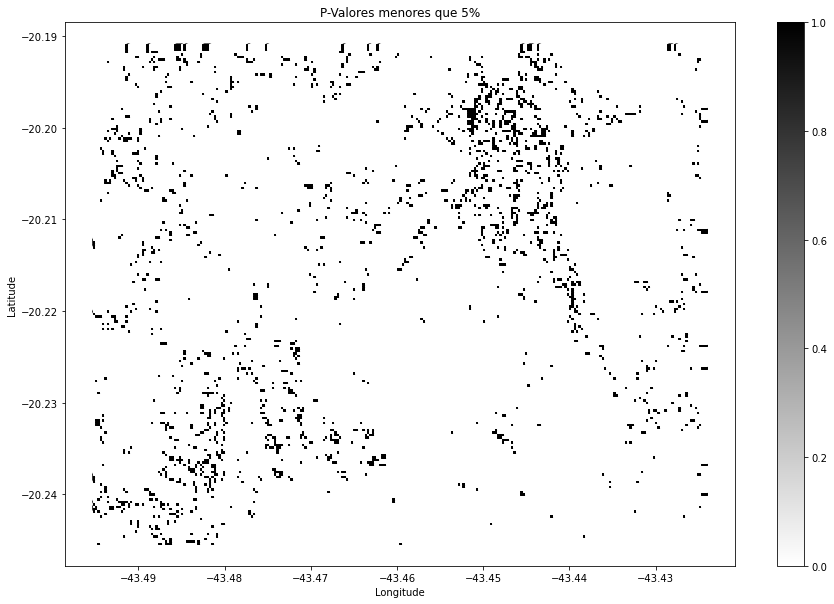

In [26]:
import matplotlib.pyplot as plt
filtro_oc = tab_res.copy()
filtro_oc.loc[tab_res['p-valor']>0.05,'p-valor'] = 0
filtro_oc.loc[tab_res['p-valor']<0.05,'p-valor'] = 1
x = filtro_oc.index.get_level_values(1).values
y = filtro_oc.index.get_level_values(0).values

mask1 = filtro_oc['p-valor'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask1,cmap='binary')
ax.set_title('P-Valores menores que 5%')
plt.colorbar(ax.scatter(x,y,c=mask1,marker=',',cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_OC_pval.png')
plt.show()

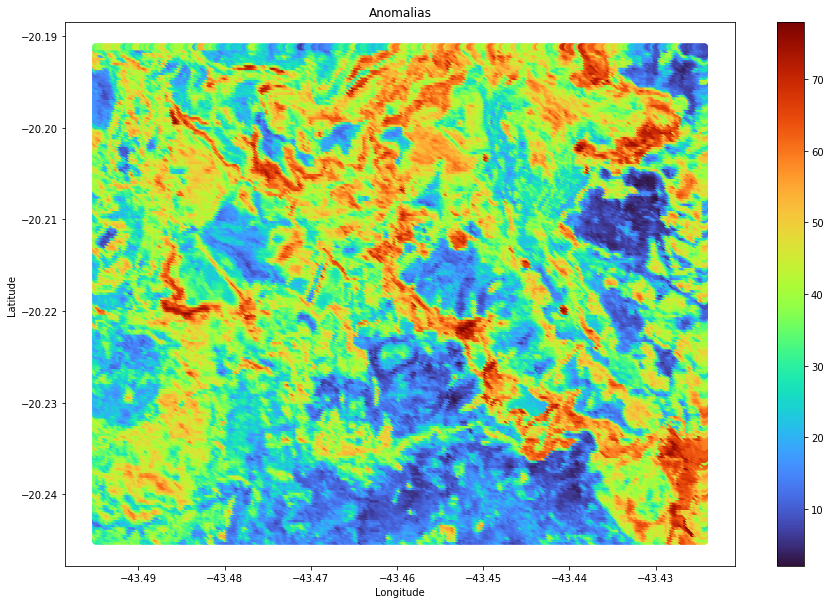

In [27]:
mask1 = tab_res['Anomalias'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask1,cmap='turbo')
ax.set_title('Anomalias')
plt.colorbar(ax.scatter(x,y,c=mask1,cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_OC_anom.png')
plt.show()

### Isolation Forest
#### Subtração da mediana + detecção de anomalias com base no padrão do dataset

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

def isola(df, occlf):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

def cria_dataf_2(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = isola(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

In [22]:
data_dict_if = {}
metric_dict_if = {}
dummy = -99999
bands = ['Anomalias','p-valor']
for i in range(5):
    valor = 20 + i*20
    classificador = IsolationForest(n_estimators=valor,n_jobs=-1).fit(array_reg)
    
    tab_ex = cria_dataf_2(df_r30, classificador)
    data_dict_if[i] = tab_ex
    tab_res = Aplica_Metricas(tab_ex)
    metric_dict_if[i] = tab_res
    path_out = 'Tiff/V4_Out_22/Mari_NDWI_IF_' + str(i) + '.tif'
    save_tiff_fromdf(tab_res,bands,dummy,path_out)
    print(i)

0
1
2
3
4


## NDWI Application

In [28]:
listaCN = col_ajust.toList(col_ajust.size())
defaultDummy = -99999
df_ndwi = pd.DataFrame()
dias = ndvi_df['Timestamp'].values
di = {}
for j in range(col_ajust.size().getInfo()):
    tempndvi = dias[j]
    img = ee.Image(defaultDummy).blend(ee.Image(listaCN.get(j)))
    lat30, lon30, ind30 = ext_lat_lon_pixel30(img,geometria,['ndwi'])
    di[tempndvi] = ind30[0]
    
df_ndwi = df_ndwi.from_dict(di)
df_ndwi = df_ndwi.assign(Latitude = lat30)
df_ndwi = df_ndwi.assign(Longitude = lon30)
df_ndwi = df_ndwi.set_index(['Latitude','Longitude'])
df_ndwi.head()

2013-05-05 12:59:11.640  2013-05-21 12:59:24.700  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.037815                 0.002116   
           -43.494674                 0.042540                -0.004304   
           -43.494405                 0.031810                -0.035382   
           -43.494135                 0.035258                -0.001677   
           -43.493866                 0.026628                 0.005111   

                       2013-07-08 12:59:22.150  2013-08-02 12:53:12.400  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.036192                 0.009540   
           -43.494674                 0.041451                 0.001703   
           -43.494405                 0.027635                -0.013667   
           -43.494135                -0.001939                -0.000872   
           -43.493866                -0.025126                 0.005679   

                       2013-08-09 12:59:23.530  2013-08-25 12:59:25.670  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.022873                -0.015601   
           -43.494674                -0.027844                 0.006413   
           -43.494405                -0.040571                -0.016441   
           -43.494135                -0.016944                -0.007653   
           -43.493866                -0.028339                -0.033183   

                       2013-10-28 12:59:05.186  2014-06-09 12:57:03.660  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.011630                 0.005437   
           -43.494674                 0.026049                -0.019652   
           -43.494405                 0.000401                -0.004289   
           -43.494135                -0.023756                 0.035235   
           -43.493866                -0.022427                 0.016315   

                       2014-06-25 12:57:05.490  2014-08-05 12:51:12.720  ...  \
Latitude   Longitude                                                     ...   
-20.245107 -43.494944            -1.964808e-02                -0.051210  ...   
           -43.494674            -2.726089e-03                -0.065826  ...   
           -43.494405            -2.629418e-02                -0.052363  ...   
           -43.494135             4.572395e-03                -0.013920  ...   
           -43.493866             8.251201e-10                -0.042119  ...   

                       2020-09-13 12:57:37.029  2020-09-29 12:57:41.342  \
Latitude   Longitude                                                      
-20.245107 -43.494944                -0.005331                -0.059787   
           -43.494674                 0.009621                -0.057700   
           -43.494405                -0.022834                -0.088285   
           -43.494135                -0.026116                -0.078162   
           -43.493866                -0.041456                -0.087083   

                       2021-01-19 12:57:31.376  2021-03-24 12:57:11.126  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.065679                 0.065955   
           -43.494674                 0.086330                 0.058666   
           -43.494405                 0.088825                 0.050460   
           -43.494135                 0.054088                 0.063697   
           -43.493866                 0.051037                 0.052000   

                       2021-04-25 12:56:58.935  2021-05-11 12:56:55.410  \
Latitude   Longitude                                                      
-20.245107 -43.494944                 0.039010                 0.044729   
           -43.494674                 0.032329                 0.012301   
      

In [29]:
oc_ndwi = df_ndwi.values.reshape(-1,1)
dpoc = np.std(oc_ndwi)
meanoc = np.mean(oc_ndwi)
print(dpoc, meanoc)

0.11553211693166697 -0.009925051851042414


In [30]:
ndwireg = []
alpha = float(input('digite o valore de alpha'))
inf_lim = meanoc - alpha*dpoc
sup_lim = meanoc + alpha*dpoc
for i in oc_val:
    if inf_lim < i < sup_lim:
        ndwireg.append(i)
        
arrndwi_reg = np.asarray(ndwireg)
len(arrndwi_reg)

digite o valore de alpha0.5


2320679

In [31]:
novo_data = int(0.05 * len(arrndwi_reg))
dataind = np.random.choice(len(arrndwi_reg),size=novo_data)
ndwi_data = arrndwi_reg[dataind]
len(ndwi_data)

116033

### One-Class SVM

In [32]:
occlf = OneClassSVM(nu=0.05).fit(ndwi_data)

def OCSVM2(df):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

In [33]:
ndwi_teste = pd.DataFrame(index = df_ndwi.index, columns = df_ndwi.columns)
ndwi_teste = ndwi_teste.append(df_ndwi.apply(OCSVM2, axis=1), ignore_index=False).dropna()
ndwi_teste.tail()

2013-05-05 12:59:11.640 2013-05-21 12:59:24.700  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                      -1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2013-07-08 12:59:22.150 2013-08-02 12:53:12.400  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2013-08-09 12:59:23.530 2013-08-25 12:59:25.670  \
Latitude   Longitude                                                    
-20.191208 -43.425414                      -1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                      -1                       1   

                      2013-10-28 12:59:05.186 2014-06-09 12:57:03.660  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                      -1                       1   
           -43.424336                       1                       1   

                      2014-06-25 12:57:05.490 2014-08-05 12:51:12.720  ...  \
Latitude   Longitude                                                   ...   
-20.191208 -43.425414                       1                       1  ...   
           -43.425145                       1                       1  ...   
           -43.424875                       1                       1  ...   
           -43.424606                       1                       1  ...   
           -43.424336                       1                       1  ...   

                      2020-09-13 12:57:37.029 2020-09-29 12:57:41.342  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                      -1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                      -1   
           -43.424336                       1                      -1   

                      2021-01-19 12:57:31.376 2021-03-24 12:57:11.126  \
Latitude   Longitude                                                    
-20.191208 -43.425414                      -1                      -1   
           -43.425145                      -1                      -1   
           -43.424875                      -1                      -1   
           -43.424606                      -1                      -1   
           -43.424336                      -1                      -1   

                      2021-04-25 12:56:58.935 2021-05-11 12:56:55.410  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                 

In [34]:
ndwi_octab = pd.DataFrame()
ndwi_octab.loc[:,'Anomalias'] = ndwi_teste.apply(contador_anomaly, axis=1)
ndwi_octab.loc[:,'Regular'] = ndwi_teste.apply(contador_reg, axis=1)
ndwi_octab.loc[:,'Mudanças'] = ndwi_teste.apply(transitions, axis=1)
ndwi_octab.loc[:,'Permanece Regular'] = ndwi_teste.apply(mantem_normal, axis=1)
ndwi_octab.loc[:,'Permanece Anomalia'] = ndwi_teste.apply(mantem_anomalia, axis=1)
ano = ndwi_octab['Anomalias']; reg = ndwi_octab['Regular']; mud = ndwi_octab['Mudanças']
media = np.mean(mud)
stdev = np.std(mud)
ndwi_octab.loc[:,'media'] = media
ndwi_octab.loc[:,'std'] = stdev
ndwi_octab.loc[:,'z'] = (mud - media)/stdev
ndwi_octab.loc[:,'p-valor'] = ndwi_octab.loc[:,'z'].apply(p_valor)
ndwi_octab

Anomalias  Regular  Mudanças  Permanece Regular  \
Latitude   Longitude                                                     
-20.245107 -43.494944         27       52        31                 36   
           -43.494674         36       43        23                 31   
           -43.494405         31       48        27                 34   
           -43.494135         32       47        29                 32   
           -43.493866         31       48        25                 35   
...                          ...      ...       ...                ...   
-20.191208 -43.425414         28       51        35                 33   
           -43.425145         30       49        31                 33   
           -43.424875         27       52        35                 34   
           -43.424606         30       49        31                 33   
           -43.424336         25       54        29                 39   

                       Permanece Anomalia      media       std         z  \
Latitude   Longitude                                                       
-20.245107 -43.494944                  11  26.432098  6.462044  0.706882   
           -43.494674                  24  26.432098  6.462044 -0.531116   
           -43.494405                  17  26.432098  6.462044  0.087883   
           -43.494135                  17  26.432098  6.462044  0.397382   
           -43.493866                  18  26.432098  6.462044 -0.221617   
...                                   ...        ...       ...       ...   
-20.191208 -43.425414                  10  26.432098  6.462044  1.325881   
           -43.425145                  14  26.432098  6.462044  0.706882   
           -43.424875                   9  26.432098  6.462044  1.325881   
           -43.424606                  14  26.432098  6.462044  0.706882   
           -43.424336                  10  26.432098  6.462044  0.397382   

                        p-valor  
Latitude   Longitude             
-20.245107 -43.494944  0.239820  
           -43.494674  0.702331  
           -43.494405  0.464985  
           -43.494135  0.345543  
           -43.493866  0.587694  
...                         ...  
-20.191208 -43.425414  0.092440  
           -43.425145  0.239820  
           -43.424875  0.092440  
           -43.424606  0.239820  
           -43.424336  0.345543  

[52863 rows x 9 columns]

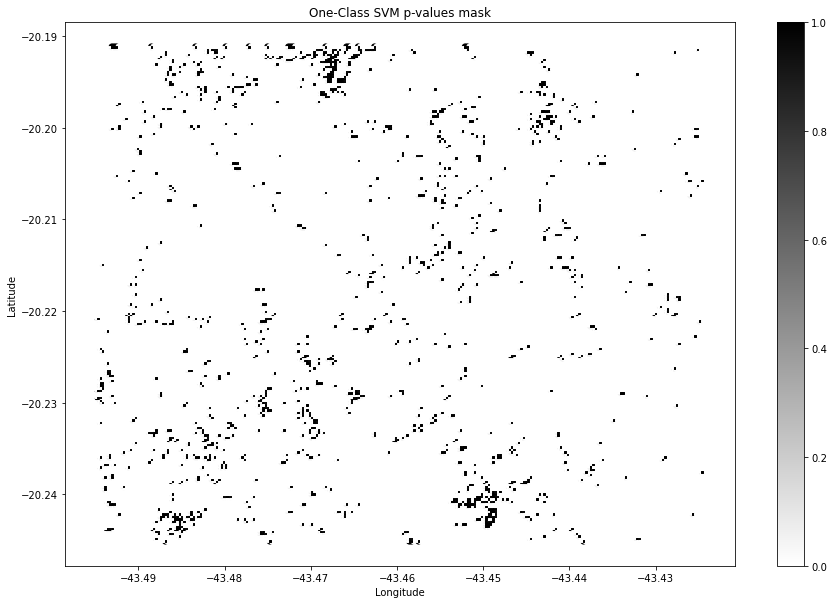

In [35]:
ft_ndwi_oc = ndwi_octab.copy()
ft_ndwi_oc.loc[ndwi_octab['p-valor']>0.05,'p-valor'] = 0
ft_ndwi_oc.loc[ndwi_octab['p-valor']<0.05,'p-valor'] = 1
x = ft_ndwi_oc.index.get_level_values(1).values
y = ft_ndwi_oc.index.get_level_values(0).values

mask2 = ft_ndwi_oc['p-valor'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask2,cmap='binary')
ax.set_title('One-Class SVM p-values mask')
plt.colorbar(ax.scatter(x,y,c=mask2,marker=',',s=2,cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_IF_pval.png')
plt.show()

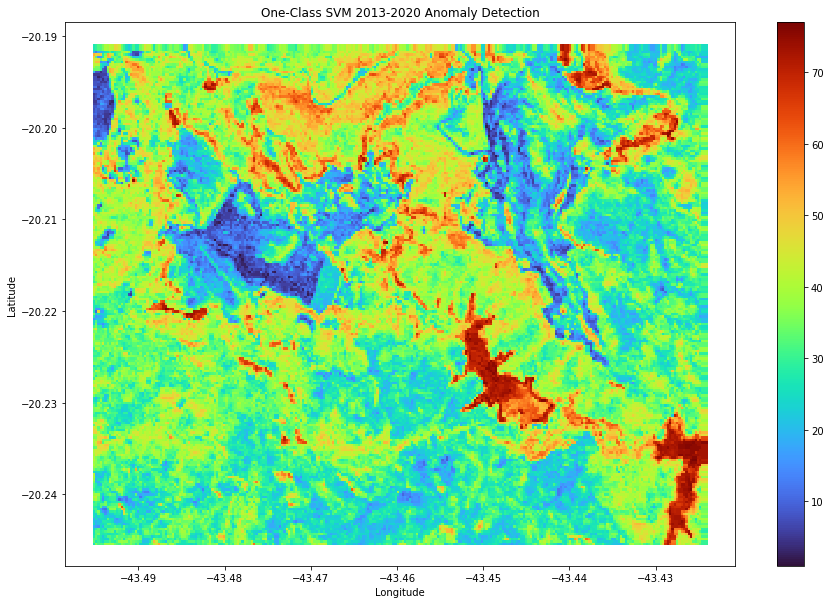

In [36]:
mask3 = ndwi_octab['Anomalias'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask3,marker=',',cmap='turbo')
ax.set_title('One-Class SVM 2013-2020 Anomaly Detection')
plt.colorbar(ax.scatter(x,y,c=mask3,marker=',',cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30__NDVI_IF_anom.png')
plt.show()

### Isolation Forest

In [37]:
classificador3 = IsolationForest(n_estimators=40,random_state=0,
                                n_jobs=-1,max_samples='auto').fit(oc_ndwi)
def isola3(df):
    x = df.to_numpy().reshape(-1,1)
    res = classificador3.predict(x)
    ser = pd.Series(res, index=df.index)
    return ser

In [38]:
ndwif_teste = pd.DataFrame(index = df_ndwi.index, columns = df_ndwi.columns)
ndwif_teste = ndwif_teste.append(df_ndwi.apply(isola3, axis=1), ignore_index=False).dropna()
ndwif_teste.tail()

2013-05-05 12:59:11.640 2013-05-21 12:59:24.700  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2013-07-08 12:59:22.150 2013-08-02 12:53:12.400  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2013-08-09 12:59:23.530 2013-08-25 12:59:25.670  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2013-10-28 12:59:05.186 2014-06-09 12:57:03.660  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2014-06-25 12:57:05.490 2014-08-05 12:51:12.720  ...  \
Latitude   Longitude                                                   ...   
-20.191208 -43.425414                       1                       1  ...   
           -43.425145                       1                       1  ...   
           -43.424875                       1                       1  ...   
           -43.424606                       1                       1  ...   
           -43.424336                       1                       1  ...   

                      2020-09-13 12:57:37.029 2020-09-29 12:57:41.342  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2021-01-19 12:57:31.376 2021-03-24 12:57:11.126  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                       1                       1   
           -43.424336                       1                       1   

                      2021-04-25 12:56:58.935 2021-05-11 12:56:55.410  \
Latitude   Longitude                                                    
-20.191208 -43.425414                       1                       1   
           -43.425145                       1                       1   
           -43.424875                       1                       1   
           -43.424606                 

In [39]:
ndwi_iftab = pd.DataFrame()
ndwi_iftab.loc[:,'Anomalias'] = ndwif_teste.apply(contador_anomaly, axis=1)
ndwi_iftab.loc[:,'Regular'] = ndwif_teste.apply(contador_reg, axis=1)
ndwi_iftab.loc[:,'Mudanças'] = ndwif_teste.apply(transitions, axis=1)
ndwi_iftab.loc[:,'Permanece Regular'] = ndwif_teste.apply(mantem_normal, axis=1)
ndwi_iftab.loc[:,'Permanece Anomalia'] = ndwif_teste.apply(mantem_anomalia, axis=1)
ano = ndwi_iftab['Anomalias']; reg = ndwi_iftab['Regular']; mud = ndwi_iftab['Mudanças']
media = np.mean(mud)
stdev = np.std(mud)
ndwi_iftab.loc[:,'media'] = media
ndwi_iftab.loc[:,'std'] = stdev
ndwi_iftab.loc[:,'z'] = (mud - media)/stdev
ndwi_iftab.loc[:,'p-valor'] = ndwi_iftab.loc[:,'z'].apply(p_valor)
ndwi_iftab

Anomalias  Regular  Mudanças  Permanece Regular  \
Latitude   Longitude                                                     
-20.245107 -43.494944          5       74         7                 70   
           -43.494674          5       74         7                 70   
           -43.494405          7       72        11                 66   
           -43.494135          7       72        11                 66   
           -43.493866          8       71        13                 64   
...                          ...      ...       ...                ...   
-20.191208 -43.425414          6       73         8                 68   
           -43.425145          4       75         6                 71   
           -43.424875          5       74         5                 71   
           -43.424606          7       72         9                 67   
           -43.424336          6       73         9                 68   

                       Permanece Anomalia      media       std         z  \
Latitude   Longitude                                                       
-20.245107 -43.494944                   1  12.278891  6.536974 -0.807543   
           -43.494674                   1  12.278891  6.536974 -0.807543   
           -43.494405                   1  12.278891  6.536974 -0.195640   
           -43.494135                   1  12.278891  6.536974 -0.195640   
           -43.493866                   1  12.278891  6.536974  0.110312   
...                                   ...        ...       ...       ...   
-20.191208 -43.425414                   2  12.278891  6.536974 -0.654567   
           -43.425145                   1  12.278891  6.536974 -0.960519   
           -43.424875                   2  12.278891  6.536974 -1.113495   
           -43.424606                   2  12.278891  6.536974 -0.501592   
           -43.424336                   1  12.278891  6.536974 -0.501592   

                        p-valor  
Latitude   Longitude             
-20.245107 -43.494944  0.790323  
           -43.494674  0.790323  
           -43.494405  0.577554  
           -43.494135  0.577554  
           -43.493866  0.456081  
...                         ...  
-20.191208 -43.425414  0.743627  
           -43.425145  0.831603  
           -43.424875  0.867252  
           -43.424606  0.692023  
           -43.424336  0.692023  

[52863 rows x 9 columns]

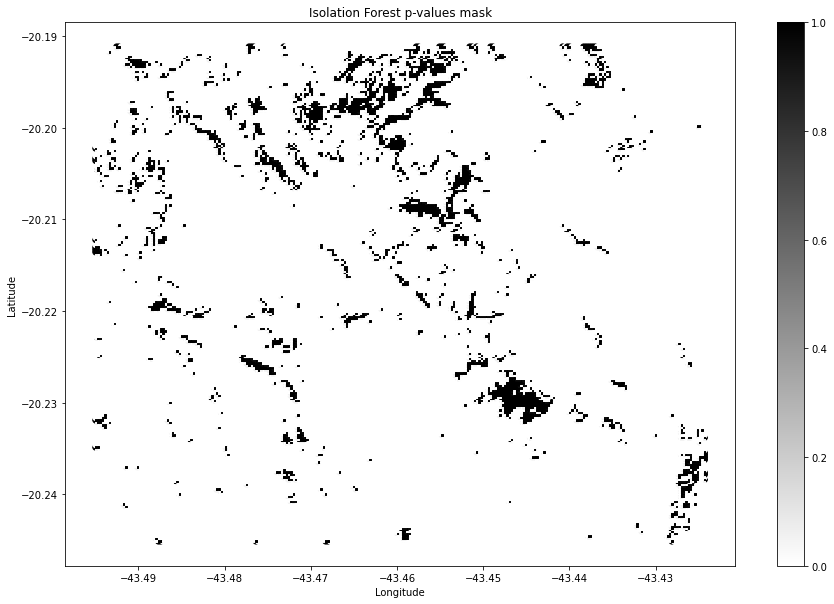

In [40]:
ft_ndwi_if = ndwi_iftab.copy()
ft_ndwi_if.loc[ndwi_iftab['p-valor']>0.05,'p-valor'] = 0
ft_ndwi_if.loc[ndwi_iftab['p-valor']<0.05,'p-valor'] = 1
x = ft_ndwi_if.index.get_level_values(1).values
y = ft_ndwi_if.index.get_level_values(0).values

mask2 = ft_ndwi_if['p-valor'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask2,cmap='binary')
ax.set_title('Isolation Forest p-values mask')
plt.colorbar(ax.scatter(x,y,c=mask2,marker=',',s=2,cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_IF_pval.png')
plt.show()

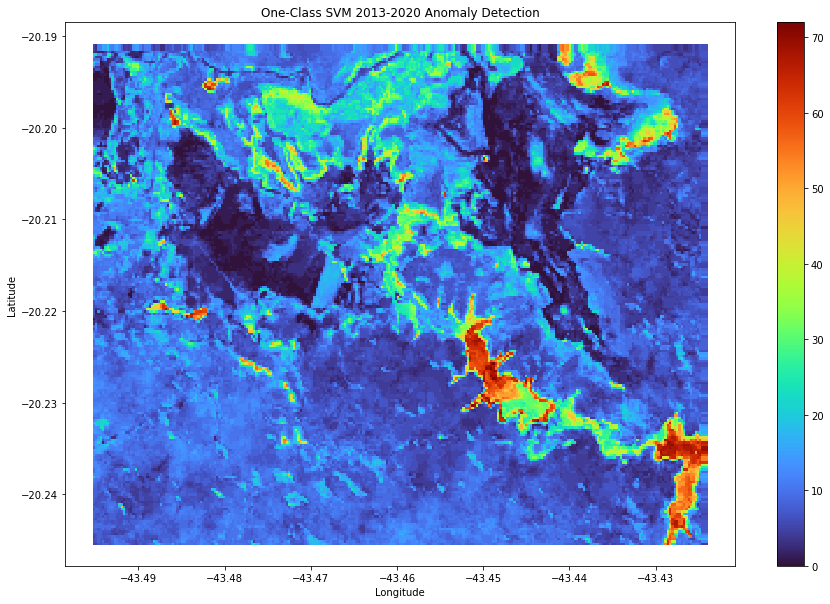

In [41]:
mask3 = ndwi_iftab['Anomalias'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask3,marker=',',cmap='turbo')
ax.set_title('One-Class SVM 2013-2020 Anomaly Detection')
plt.colorbar(ax.scatter(x,y,c=mask3,marker=',',cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30__NDVI_IF_anom.png')
plt.show()

In [42]:
dataframes_metodos = [ft_ndwi_oc,ft_ndwi_if]
metodos = ['OCSVM','IF']
for i in range(len(dataframes_metodos)):
    path_out = 'Tiff//Mariana_2022' + metodos[i] + '_NDWI.tif'
    bands = ['Anomalias','p-valor']
    save_tiff_fromdf(dataframes_metodos[i],bands,defaultDummy,path_out)